In [1]:
import os
import numpy as np
import quaternion

import torch
from torch import nn
from torchvision import transforms
from PIL import Image
from kornia.geometry.depth import warp_frame_depth

import matplotlib.pyplot as plt
import moviepy.editor as mpy
from IPython import display

/home/troy/.local/lib/python3.8/site-packages/kornia/augmentation/augmentation.py:1872: DeprecationWarning: GaussianBlur is no longer maintained and will be removed from the future versions. Please use RandomGaussianBlur instead.
  warnings.warn(


In [2]:
saw = lambda x: 1 - abs(x % 2 - 1)
ease_quad = lambda x: 2 * x**2 if x < 0.5 else 1 - (-2 * x + 2)**2 / 2

In [3]:
# https://github.com/Fyusion/LLFF

def load_poses_bounds_llff(scenedir):
    poses_arr = np.load(os.path.join(scenedir, 'poses_bounds.npy'))
    poses = poses_arr[:, :-2].reshape([-1, 3, 5]).transpose([1,2,0])
    bds = poses_arr[:, -2:].transpose([1,0])

    # Correct rotation matrix ordering and move variable dim to axis 0
    poses = np.concatenate([poses[:, 1:2, :], -poses[:, 0:1, :], poses[:, 2:, :]], 1)
    poses = np.moveaxis(poses, -1, 0).astype(np.float32)
    bds = np.moveaxis(bds, -1, 0).astype(np.float32)
    
    hwf = poses[0, :3, -1]
    poses = poses[:, :3, :4]
    
    return poses, bds, hwf

def get_rays_np(H, W, focal, c2w):
    """Get ray origins, directions from a pinhole camera."""
    i, j = np.meshgrid(np.arange(W, dtype=np.float32),
                       np.arange(H, dtype=np.float32), indexing='xy')
    dirs = np.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -np.ones_like(i)], -1)
    rays_d = np.sum(dirs[..., np.newaxis, :] * c2w[:3, :3], -1)
    #rays_d = np.sum(dirs[..., np.newaxis, :] * np.array([[1,0,0],[0,1,0],[0,0,1]]), -1).astype(np.float32)
    #rays_o = np.broadcast_to(c2w[:3, -1], np.shape(rays_d))
    rays_o = c2w[:3, -1]
    return rays_o, rays_d


def get_x_image(H, W, focal, c2w):
    ro, rd = get_rays_np(H, W, focal, c2w)
    ro = torch.tensor(ro)
    rd = torch.tensor(rd).reshape(-1, 3)
    rd = rd / rd.norm(dim=-1, keepdim=True)
    return ro, rd

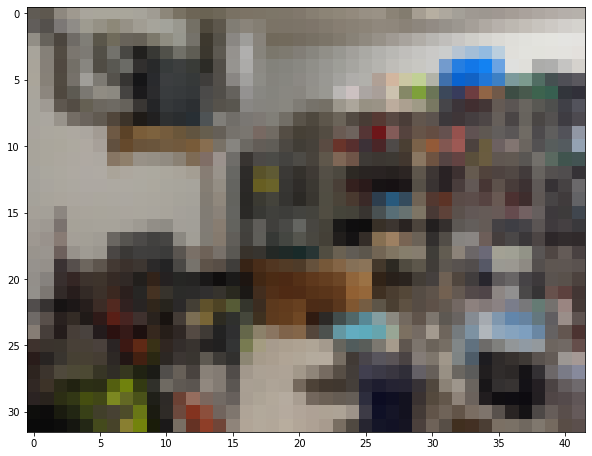

In [4]:
scenedir = '../grodge'

transform=transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor()
])
img_folder = os.path.join(scenedir, 'images')
images = [transform(Image.open(os.path.join(img_folder, v)))
          for v in sorted(os.listdir(img_folder))]
images = torch.stack(images, axis=0)

plt.figure(figsize=(10,)*2)
plt.imshow(images[0].permute(1,2,0))

In [5]:
poses, bds, hwf = load_poses_bounds_llff(scenedir)
print('Camera position mean & std:')
print(poses[:,:,-1].mean(axis=0), poses[:,:,-1].std(axis=0))

H, W = images[0].shape[1:]
focal = H / hwf[0] * hwf[2]

class Data:
    def __init__(self):
        self.origins = []
        self.raydirs = []
        self.colors = []
data = Data()

for i in range(len(poses)):
    ro, rd = get_x_image(H, W, focal, poses[i])
    data.origins.append(ro[None, :])
    data.raydirs.append(rd)
    data.colors.append(images[i].permute(1,2,0).reshape(-1, 3))

data.origins = torch.cat(data.origins, axis=0)
data.raydirs = torch.cat(data.raydirs, axis=0)
data.colors = torch.cat(data.colors, axis=0)

Camera position mean & std:
[0.5587934  0.4400115  0.29173553] [3.122544  2.0582294 0.9369718]


## Learn Depth Maps

In [6]:
x = torch.rand(3, requires_grad=True)
y = torch.tensor([0, 0.5, 1])
o = torch.optim.Adam([x], lr=0.01)
lf = nn.MSELoss()

print(x)
for i in range(40):
    l = lf(x,y)
    o.zero_grad()
    l.backward()
    o.step()
print(x)

tensor([0.0189, 0.4752, 0.6593], requires_grad=True)
tensor([8.3543e-04, 5.0220e-01, 9.7715e-01], requires_grad=True)


In [7]:
min_depth, max_depth = min(bds[:, 0]), max(bds[:, 1])
print(min_depth, max_depth)
depth_maps = torch.rand(images.shape[0], 1, *images.shape[2:], requires_grad=True)
#with torch.no_grad():
    #depth_maps = depth_maps * (max_depth - min_depth) + min_depth

8.885932 37.61952


-0.20187652111053467 1.3268457651138306


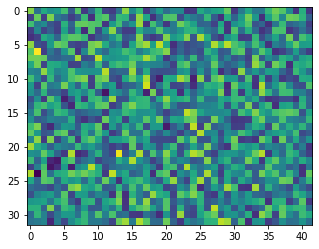

In [8]:
depth_optim = torch.optim.Adam([depth_maps], lr=0.01)
depth_loss_fn = nn.MSELoss()

cam_intrinsics = torch.tensor([[
    [W, 0, W/2],
    [0, H, H/2],
    [0, 0, 1]
]])

for i in range(200):
    src_id, dst_id = np.random.choice(images.shape[0], 2, replace=False)
    image_src = images[src_id][None, :]
    image_dst = images[dst_id][None, :]
    depth_dst = depth_maps[dst_id][None, :]  * (max_depth - min_depth) + min_depth
    
    pose_src_quat = quaternion.from_rotation_matrix(poses[src_id])
    pose_dst_quat = quaternion.from_rotation_matrix(poses[dst_id])
    src_trans_dst = quaternion.as_rotation_matrix(pose_dst_quat * pose_src_quat.inverse())
    src_offset = poses[src_id, :, -1] - poses[dst_id, : , -1]
    src_trans_dst = np.concatenate([src_trans_dst, src_offset[:, None]], axis=-1)
    src_trans_dst = np.concatenate([src_trans_dst, np.array([0,0,0,1])[None, :]], axis=0)
    src_trans_dst = torch.tensor(src_trans_dst.astype(np.float32))[None, :]
    
    warped = warp_frame_depth(image_src, depth_dst, src_trans_dst, cam_intrinsics, normalize_points=True)
    
    loss = depth_loss_fn(warped, image_dst)
    depth_optim.zero_grad()
    loss.backward()
    depth_optim.step()

mind = depth_maps[0].min()
maxd = depth_maps[0].max()
print(mind.item(), maxd.item())
normd = (depth_maps[0] - mind) / (maxd - mind)
plt.imshow(normd.detach().cpu().permute(1,2,0))

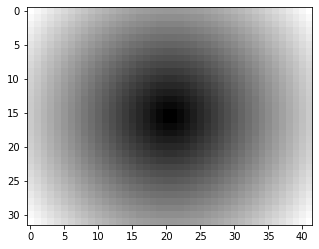

In [9]:
y, x = torch.meshgrid(torch.linspace(-H/W, H/W, H), torch.linspace(-1, 1, W))
dm_test = torch.stack([y, x], axis=0)
dm_test = dm_test.norm(dim=0, keepdim=True)
dm_test = dm_test / dm_test.max() * (max_depth - min_depth) + min_depth
plt.imshow((dm_test / dm_test.max()).permute(1,2,0), cmap='gray')

In [10]:
qi = pose_src_quat * pose_src_quat.inverse()
qir = quaternion.as_rotation_matrix(qi)
print(qir)

[[ 1.00000000e+00 -1.73472348e-18  0.00000000e+00]
 [ 1.73472348e-18  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [11]:
src_id, dst_id = 0, 4
image_src = images[src_id][None, :]
image_dst = images[dst_id][None, :]
depth_dst = dm_test[None, :]
#depth_dst = torch.ones(1, 1, *image_src.shape[2:]) * max_depth

pose_src_quat = quaternion.from_rotation_matrix(poses[src_id])
pose_dst_quat = quaternion.from_rotation_matrix(poses[dst_id])

def make_warp_frame(t):
    t = ease_quad(saw(t))
    
    src_offset = (poses[dst_id, : , -1] - poses[src_id, :, -1]) * t
    a = np.array
    q_t = quaternion.quaternion_time_series.squad(a([pose_dst_quat, pose_src_quat]), a([0, 1]), a([t]))[0]
    src_trans_dst = quaternion.as_rotation_matrix(pose_dst_quat * q_t.inverse())
    src_trans_dst = np.concatenate([src_trans_dst, src_offset[:, None]], axis=-1)
    src_trans_dst = np.concatenate([src_trans_dst, np.array([0,0,0,1])[None, :]], axis=0)
    src_trans_dst = torch.tensor(src_trans_dst.astype(np.float32))[None, :]
    
    warped = warp_frame_depth(image_src, depth_dst, src_trans_dst, cam_intrinsics, normalize_points=True)
    return warped[0].permute(1,2,0).multiply(255).int().numpy()

clip = mpy.VideoClip(make_warp_frame, duration=2)
clip.write_videofile('warp.mp4', fps=12)

display.clear_output()
display.display(display.HTML('<video src="warp.mp4" controls=true autoplay=true loop=true width=300px/>'))